In [25]:
import pybar.pybar_tom as pybar
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mc
from matplotlib import cm
import pandas as pd
from tqdm import tqdm
import functions as f
from pathlib import Path
import time

In [26]:
beta = np.deg2rad(50)
i    = np.deg2rad(80)
to_Myr = 9.78462
bar_length = 2.6
err_vr = 0.1
err_rho = 0.05

In [27]:
t = 20
case = 'strongbar'
X, Y, VX, VY, RHO = np.load(f'./../simulation/simulation/output_npy/{case}/data_{t}.npy')
FIG_DIR = Path('./../figures/')

In [28]:
# check solid body rotation with uniform disk
VX  = np.zeros_like(VX)
VY  = np.zeros_like(VX)
RHO = np.ones_like(RHO) * np.exp(- np.sqrt(10) / 3 * np.sqrt (X ** 2 + Y ** 2))
case = 'perfectdisk'

In [29]:
X, Y, VX, VY = f.rotate_bar(beta, X, Y, VX, VY)
VX, VY = f.add_solid_body_rotation(X, Y, VX, VY, 0.4)
X, Y, VR = f.incline_galaxy(i, X, Y, VX, VY)

### pixelation

In [30]:
step_final   = 0.1
step_initial = 0.07

RHO_array = RHO.copy()
VR_array  = VR.copy()
x_center_array, y_center_array = X.copy(), Y.copy()

# RHO_array, [x_center_array, y_center_array] = f.mean_in_pixel(X, Y, step_initial, RHO, if_xy=True)
# VR_array           = f.mean_in_pixel(X, Y, step_initial, VR * RHO) / RHO_array

### uncertainties

In [31]:
VR_err = err_vr * np.ones_like(VR_array)
RHO_err = err_rho * RHO_array

VR_array, RHO_array = f.add_uncertanties(VR_array, RHO_array, err_vr, err_rho * RHO_array)

pa_uncertainty = 0#np.random.uniform(-2, 2)
x_center_array, y_center_array, _, _ = f.rotate_bar(np.deg2rad(pa_uncertainty), x_center_array, y_center_array, 0, 0)
# x_center_array += np.random.normal(loc=0, scale=0.1)
# x_center_array += np.random.normal(loc=0, scale=0.1)

### integrating

In [32]:
bar = pybar.mybar(Flux=RHO_array, Flux_err=RHO_err,
                  Velocity=VR_array, Velocity_err=VR_err,
                  Yin=y_center_array, Xin=x_center_array,
                  slit_width=step_final,
                  inclin=np.rad2deg(i), PAnodes=-90, beta=np.rad2deg(beta), if_symmetrize=False)

bar.tremaine_weinberg()

### fitting

In [33]:
omega_bar, omega_bar_err, c, c_err, x_tw, v_tw, x_tw_err, v_tw_err = f.fit(bar) ### 1-line code

In [34]:
import os
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021/bin/universal-darwin'
#print(os.getenv("PATH"))

plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

plt.rc('text', usetex=True)

In [35]:
plasma = cm.get_cmap('plasma', len(x_tw))
colors = plasma.colors

x_fit = np.linspace(np.nanmin(x_tw), np.nanmax(x_tw), 3)
y_GT  = (x_fit * 40) * np.sin(i) + c * 100
y_fit = (x_fit * omega_bar * 100) + c * 100

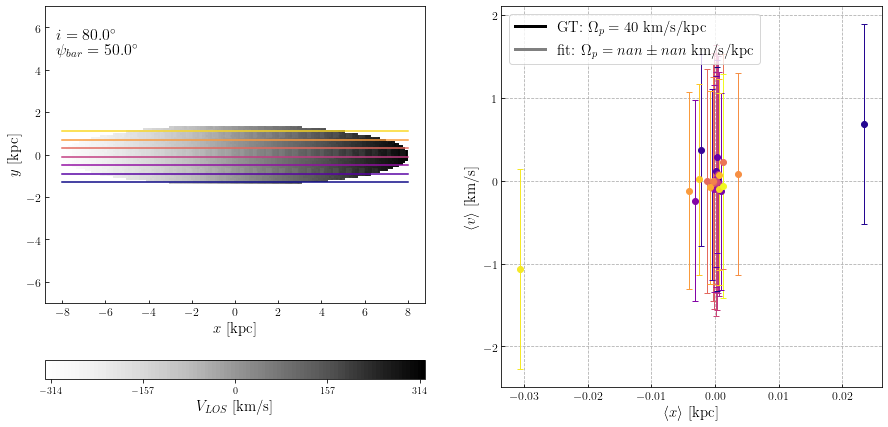

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

levels = np.linspace(np.nanmin(VR) * 100 - 10, np.nanmax(VR) * 100 + 10, 101)
cbarticks = np.linspace(np.nanmin(VR).round(2) * 100 , np.nanmax(VR).round(2) * 100 , 5)
norm = mc.BoundaryNorm(levels, 256)

ax1 = ax[0]
ax2 = ax[1]

sc = ax1.scatter(bar.X_lon, bar.Y_lon, c=bar.Vel * 100, 
                 cmap='Greys', norm=norm, marker='s', s=3)
# sc = ax1.scatter(bar.X_lon, bar.Y_lon, c=bar.Flux, 
#                  cmap='gray', norm=norm, s=1.3, alpha=0.4)
for index, y in enumerate(bar.y_slits):
    if index % 4 == 0:
        ax1.plot([-8, 8], [y, y], c=colors[index])
ax1.set_xlabel(r'$x$ [kpc]', fontsize=15)
ax1.set_ylabel(r'$y$ [kpc]', fontsize=15)
ax1.tick_params(labelsize=12, direction='in')
# ax1.annotate(r'$t=%.1f\, \rm Myr$' % (t * to_Myr), xy=(0.03, 0.94),
#              xycoords='axes fraction', fontsize=16, color='k')
ax1.annotate(r'$i=%.1f ^{\circ}$' % (np.rad2deg(i)), xy=(0.03, 0.89),
             xycoords='axes fraction', fontsize=16, color='k')
ax1.annotate(r'$\psi_{bar}=%.1f ^{\circ}$' % (np.rad2deg(beta)), xy=(0.03, 0.84),
             xycoords='axes fraction', fontsize=16, color='k')

ax1.set_ylim(-7, 7)
cbar = plt.colorbar(sc, ax=ax1, orientation="horizontal", fraction=0.07, ticks=cbarticks)
cbar.set_label(label=r'$V_{LOS}$ [km/s]', size=15)

ax2.plot(x_fit, y_GT,
        c='black', lw=3, label=r'GT: $\Omega_p = 40$ km/s/kpc')
ax2.plot(x_fit, y_fit, 
        c='gray', lw=3, label=fr'fit: $\Omega_p = {(omega_bar * 100 / np.sin(i)).round(1)} \pm {(omega_bar_err * 100 / np.sin(i)).round(1)} $ km/s/kpc')

for x, y, e1, e2, color in zip(x_tw, v_tw * 100, x_tw_err, v_tw_err * 100, colors):
    ax2.errorbar(x, y, xerr=e1, yerr=e2, lw=1, capsize=3, color=color, marker='o')
# ax2.annotate(text='errors: 0.01 km/s, density 10%', xy=(4,10), xytext=(0.5,0.5))

# ax2.annotate(f'errors: \n {err_vr * 100} km/s, \n density {err_rho * 100} \%',
#             xy=(0, 0.5),
#             xycoords='axes fraction',
#             xytext=(0.7, 0.1), fontsize=15)



ax2.tick_params(labelsize=12,direction='in')
ax2.set_xlabel(r' $\langle x \rangle$ [kpc]', fontsize=15)
ax2.set_ylabel(r' $\langle v \rangle$ [km/s]', fontsize=15)
ax2.legend(fontsize=15, loc='upper left')

ax2.grid(ls='dashed')
plt.savefig(FIG_DIR / f'TW_method_pybar_{t}_{err_vr * 100}_{err_rho * 100}_{case}_errors.png', bbox_inches='tight', dpi=300)